## Unequal Game solution with CCEM method

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import clear_output

Let's find guaranteed result


\begin{gather*}
\begin{cases}
x_0 = 1,\\
x_n = x_{n-1} + (u_{n} - v_{n}) \cdot dt;
\end{cases}\\\\
x_n = 1 + \sum_{i=1}^{n}(u_{i} - v_{i}) \cdot dt = 1 + (U - V)  dt, \\
R(u_1, \ldots, u_n, v_1, \ldots v_n) = R(U, V) = \left(1 + (U - V)  dt\right)^2, \\\\
\gamma^{v} = \max_{V}\min_{U} R(U, V), \\
\frac{\partial}{\partial U}R = 2 (1 + (U-V)dt) dt = 0 \; \Longrightarrow \; U - V = -\dfrac{1}{dt}, \\
\min_{U} R(U, V) = \left(1 -\dfrac{1}{dt} dt\right)^2 = 0  \; \Longrightarrow \; \gamma^{v} = 0
\end{gather*}

\begin{gather*}
\max_{V} R(U, V) = \max\left\{ R(U, 1), R(U, -1)\right\}, 
\end{gather*}

Implement environment

In [0]:
class UnequalGame:

    def __init__(self, initial_x=1, dt=0.005, terminal_time=2, u_action_max=2, v_action_max=1):
        self.u_action_max = u_action_max
        self.v_action_max = v_action_max
        self.terminal_time = terminal_time
        self.dt = dt
        self.initial_x = initial_x
        self.state = self.reset()

    def reset(self):
        self.state = np.array([0, self.initial_x])
        return self.state

    def step(self, u_action, v_action):
        t, x = self.state
        x = x + (u_action - v_action) * self.dt
        t += self.dt
        self.state = np.array([t, x])

        reward = 0
        done = False
        if t >= self.terminal_time:
            reward = x ** 2
            done = True

        return self.state, reward, done, None


Implement agent

In [0]:
class Network(torch.nn.Module):

    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.linear_1 = torch.nn.Linear(input_shape[0], 50)
        self.linear_2 = torch.nn.Linear(50, 30)
        self.linear_3 = torch.nn.Linear(30, output_shape[0])
        self.relu = torch.nn.ReLU()
        self.tang = torch.nn.Tanh()

    def forward(self, input_):
        hidden = self.relu(self.linear_1(input_))
        hidden = self.relu(self.linear_2(hidden))
        output = self.tang(self.linear_3(hidden))
        return output


class CCEMAgent(torch.nn.Module):

    def __init__(self, state_shape, action_shape, action_max, reward_param=1, percentile_param=70, noise_decrease=0.98,
                 tau=1e-2, learning_rate=1e-2, n_learning_per_fit=16):
        super().__init__()
        self.action_max = np.abs(action_max)
        self.reward_param = reward_param  # equal to 1 if agent wants to maximize reward otherwise -1
        self.percentile_param = percentile_param
        self.noise_decrease = noise_decrease
        self.noise_threshold = 1
        self.min_noise_threshold = 0.1
        self.tau = tau
        self.n_learning_per_fit = n_learning_per_fit
        self.network = Network(state_shape, action_shape)
        self.optimizer = torch.optim.Adam(params=self.network.parameters(), lr=learning_rate)

    def get_action(self, state, test=False):
        state = torch.FloatTensor(state)
        predicted_action = self.network(state).detach().numpy()
        if not test:
            noise = self.noise_threshold * np.random.uniform(low=-self.action_max, high=self.action_max)
            predicted_action = np.clip(predicted_action * self.action_max + noise, -self.action_max, self.action_max)
        return predicted_action

    def get_elite_states_and_actions(self, sessions, prefix):
        """
          Select sessions with the most or least reward
          by percentile
        """
        total_rewards = [session['total_reward'] for session in sessions]
        reward_threshold = np.percentile(total_rewards, self.percentile_param)

        elite_states = []
        elite_actions = []
        for session in sessions:
            if self.reward_param * (session['total_reward'] - reward_threshold) > 0:
                elite_states.extend(session['states'])
                elite_actions.extend(session[f'{prefix}actions'])

        return torch.FloatTensor(elite_states), torch.FloatTensor(elite_actions)

    def learn_network(self, loss):
        self.optimizer.zero_grad()
        old_network = deepcopy(self.network)
        loss.backward()
        self.optimizer.step()

        for new_parameter, old_parameter in zip(self.network.parameters(), old_network.parameters()):
            new_parameter.data.copy_((1 - self.tau) * new_parameter + self.tau * old_parameter)

        return None

    def fit(self, sessions, prefix=''):
        elite_states, elite_actions = self.get_elite_states_and_actions(sessions, prefix=prefix)

        for _ in range(self.n_learning_per_fit):
            predicted_action = self.network(elite_states)
            loss = torch.mean((predicted_action - elite_actions) ** 2)
            self.learn_network(loss)

        if self.noise_threshold > self.min_noise_threshold:
            self.noise_threshold *= self.noise_decrease

        return None


Train agents

In [0]:
def generate_session(u_agent, v_agent, env, t_max=200, test=False):
    """
    Generate session on environment with agent
    """
    states = []
    u_actions = []
    v_actions = []
    total_reward = 0
    done = False
    state = env.reset()
    while not done:
        u_action = u_agent.get_action(state, test=test)
        v_action = v_agent.get_action(state)
        next_state, reward, done, _ = env.step(u_action[0], v_action[0])
        states.append(state)
        u_actions.append(u_action)
        v_actions.append(v_action)
        total_reward += reward
        state = next_state

    return {'states': states, 'u_actions': u_actions, 'v_actions': v_actions, 'total_reward': total_reward}


def train_agents(u_agent, v_agent, env, n_epochs, n_sessions, epsilon, test=False):
    last_mean_reward = 0
    mean_rewards = []
    
    for epoch in range(n_epochs):
        sessions = [generate_session(u_agent, v_agent, env, test=test) for _ in range(n_sessions)]
        mean_reward = np.mean([session['total_reward'] for session in sessions])
        if not test:
            u_agent.fit(sessions, prefix='u_')
        v_agent.fit(sessions, prefix='v_')
        mean_rewards.append(mean_reward)
        print('epoch: {0}, mean reward: {1}'.format(epoch, mean_reward))
        # if epoch > 0:
        #    clear_output(True)
        #    plt.plot(range(len(mean_rewards)), mean_rewards)
        #    plt.show()
        if np.abs(last_mean_reward - mean_reward) < epsilon:
            break
        last_mean_reward = mean_reward
        
    return np.array(mean_rewards)

In [0]:
env = UnequalGame()
u_agent = CCEMAgent((2,), (1,), percentile_param=30, action_max=env.u_action_max, reward_param=-1)
v_agent = CCEMAgent((2,), (1,), percentile_param=70, action_max=env.v_action_max, reward_param=1)
n_epochs = 100
n_sessions = 100
epsilon = 1e-5

In [6]:
mean_rewards = train_agents(u_agent, v_agent, env, n_epochs, n_sessions, epsilon)

epoch: 0, mean reward: 0.1394366284568579
epoch: 1, mean reward: 0.21308004952002746
epoch: 2, mean reward: 2.8857746928158754
epoch: 3, mean reward: 3.782754001876468
epoch: 4, mean reward: 4.096651717650804
epoch: 5, mean reward: 4.206777886471516
epoch: 6, mean reward: 4.55027475974812
epoch: 7, mean reward: 4.764302933794429
epoch: 8, mean reward: 4.990101918382281
epoch: 9, mean reward: 5.295063939121003
epoch: 10, mean reward: 5.462086497934465
epoch: 11, mean reward: 5.643264065503258
epoch: 12, mean reward: 5.833794722225159
epoch: 13, mean reward: 6.110028922177751
epoch: 14, mean reward: 6.3280362057153035
epoch: 15, mean reward: 6.532345463263221
epoch: 16, mean reward: 6.747596700032981
epoch: 17, mean reward: 6.93401475322627
epoch: 18, mean reward: 7.08703422143608
epoch: 19, mean reward: 7.243037074396289
epoch: 20, mean reward: 7.363430648683708
epoch: 21, mean reward: 7.504628164341743
epoch: 22, mean reward: 7.675699790048519
epoch: 23, mean reward: 7.834266883800231


KeyboardInterrupt: ignored

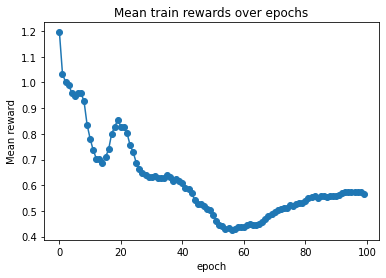

In [17]:
plt.plot(range(len(mean_rewards)), mean_rewards, '-o')
plt.xlabel('epoch')
plt.ylabel('Mean reward')
plt.title('Mean train rewards over epochs')
plt.show()

Test u_gent

In [0]:
v_test_agent = CCEMAgent((2,), (1,), percentile_param=70, action_max=env.v_action_max, reward_param=1)

In [23]:
test_rewards = train_agents(u_agent, v_test_agent, env, n_epochs, n_sessions, epsilon, test=True)

epoch: 0, mean reward: 0.7662870360627951
epoch: 1, mean reward: 0.8417469521407629
epoch: 2, mean reward: 0.9360742520044262
epoch: 3, mean reward: 0.9941326708488616
epoch: 4, mean reward: 1.0724017451337426
epoch: 5, mean reward: 1.2100500228189173
epoch: 6, mean reward: 1.3823016672138113
epoch: 7, mean reward: 1.5501204534070272
epoch: 8, mean reward: 1.7463195222447803
epoch: 9, mean reward: 1.8659108307072378
epoch: 10, mean reward: 1.9589060337811781
epoch: 11, mean reward: 2.034375373461749
epoch: 12, mean reward: 2.0853954790833353
epoch: 13, mean reward: 2.1417827617490155
epoch: 14, mean reward: 2.190854912034939
epoch: 15, mean reward: 2.2314927206629918
epoch: 16, mean reward: 2.302348888334345
epoch: 17, mean reward: 2.4063544682561497
epoch: 18, mean reward: 2.4877731568113775
epoch: 19, mean reward: 2.593605873250157
epoch: 20, mean reward: 2.7122295926164264
epoch: 21, mean reward: 2.80594429472653
epoch: 22, mean reward: 2.9189497079379265
epoch: 23, mean reward: 3.0

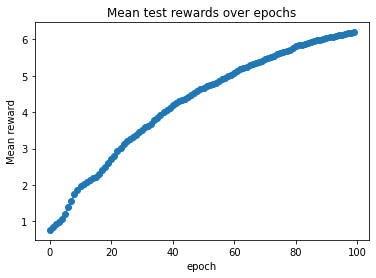

In [24]:
plt.plot(range(len(test_rewards)), test_rewards, '-o')
plt.xlabel('epoch')
plt.ylabel('Mean reward')
plt.title('Mean test rewards over epochs')
plt.show()